This file generates plots for fairness metrics in machine learning models trained with Stochastic Ghost. It provides a convenient tool for visualizing various fairness measures, such as disparate impact, equal opportunity, and predictive parity or anything specific according to the use case, to assess the performance and fairness of models across different demographic groups.

In [1]:
import os
from sklearn.metrics import roc_curve, auc, log_loss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset
from src.experiments.utils.load_folktables import load_folktables_torch

Select and load dataset

In [2]:
DATASET = 'employment_az'

X_train, y_train, [w_idx_train, nw_idx_train], X_test, y_test, [w_idx_test, nw_idx_test] = load_folktables_torch(
        'employment', state='AZ', random_state=42, make_unbalanced = False
    )

sensitive_value_0 = 'white'
sensitive_value_1 = 'non-white'

In [3]:
X_train_tensor = tensor(X_train, dtype=torch.float)
y_train_tensor = tensor(y_train, dtype=torch.float)
    
X_test_tensor = tensor(X_test, dtype=torch.float)
y_test_tensor = tensor(y_test, dtype=torch.float)
    
X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]
    
X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]


#### Load saved models

In [5]:
LOSS_BOUND = 5e-3
DATASET = 'employment_az'
DIRECTORY_PATH = "./src/experiments/utils/saved_models/" + DATASET + '/' + f'{LOSS_BOUND:.0e}' + '/'
FILE_EXT = '.pt'
DIRECTORY_PATH

'./src/experiments/utils/saved_models/employment_az/5e-03/'

In [10]:
class SimpleNet(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_shape),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [20]:
directory_path = DIRECTORY_PATH
file_list = os.listdir(directory_path)
model_files = [file for file in file_list if file.endswith(FILE_EXT)]
loaded_models = []
for model_file in model_files:
    print(model_file, end='\r')
    model_name = model_file
    model = SimpleNet(15, 1)
    model.load_state_dict(torch.load(directory_path + model_name, weights_only=False, map_location=torch.device('cpu')))
    loaded_models.append((model_file, model))

Train an uncostrained model for comparison

In [21]:
model_unconstr = SimpleNet(15, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_unconstr.parameters(), lr=5e-3)

train_ds = TensorDataset(X_train_tensor,y_train_tensor)
train_l = torch.utils.data.DataLoader(train_ds, batch_size=8)


for i, (inputs, labels) in enumerate(train_l):
    model_unconstr.zero_grad()
    outputs = model_unconstr(inputs)
    loss = loss_fn(outputs.T[0], labels)
    loss.backward()
    optimizer.step()
    print(i, end='\r')

#### Evaluate model metrics on the validation dataset

In [22]:
def get_auc(predictions, targets):
    predictions = predictions.detach().numpy()
    targets = targets

    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr, thresholds 

In [23]:
from torcheval.metrics.functional import binary_accuracy ,binary_auroc, binary_confusion_matrix

In [29]:
@torch.inference_mode() 
def make_model_stats_table(X_w, y_w, X_nw, y_nw):
    
    results_list = []
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    for model_index, model_iter in enumerate(loaded_models):
        # Set the model to evaluation mode
        (model_name, model) = model_iter

        if model_name.startswith(('AUG', 'al')):
            alg = 'AL'
        elif model_name.startswith('sg_oe'):
            alg = 'SG-OE'
        elif model_name.startswith('sg'):
            alg = 'SG'
        elif model_name.startswith('sslalm'):
            alg = 'sslalm'

        # Forward pass for subgroup with sensitive attribute A=0
        predictions_0 = model(X_w)
        predictions_1 = model(X_nw)

        # acc_0 = torch.sum(y_test_w == (predictions_0[:,0] > 0.5)) / len(predictions_0)
        # acc_1 = torch.sum(y_test_nw == (predictions_1[:,0] > 0.5)) / len(predictions_1)
        
        l_0 = loss_fn(predictions_0[:,0], y_w).numpy()
        l_1 = loss_fn(predictions_1[:,0], y_nw).numpy()
        
        predictions_0 = torch.nn.functional.sigmoid(predictions_0[:,0])
        predictions_1 = torch.nn.functional.sigmoid(predictions_1[:,0])
        acc_0 = binary_accuracy(predictions_0, y_w).numpy()
        acc_1 = binary_accuracy(predictions_1, y_nw).numpy()
        
        # Calculate AUCs for sensitive attribute 0
        fpr_0, tpr_0, thresholds_0 = roc_curve(np.array(y_w), np.array(predictions_0))
        auc_0 = auc(fpr_0, tpr_0)

        # Calculate AUCs for sensitive attribute 1
        fpr_1, tpr_1, thresholds_1 = roc_curve(np.array(y_nw), np.array(predictions_1))
        auc_1 = auc(fpr_1, tpr_1)

        auc_hm = (auc_0*auc_1)/(auc_0 + auc_1)
        auc_m = (auc_0+auc_1)/2

        # Calculate TPR-FPR difference for sensitive attribute 0
        tpr_minus_fpr_0 = tpr_0 - fpr_0
        optimal_threshold_index_0 = np.argmax(tpr_minus_fpr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate TPR-FPR difference for sensitive attribute 1
        tpr_minus_fpr_1 = tpr_1 - fpr_1
        optimal_threshold_index_1 = np.argmax(tpr_minus_fpr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]

        # Store results in the DataFrame
        results_list.append({'Model': str(model_name),
                             'Algorithm': alg,
                                        'AUC_Sensitive_0': auc_0,
                                        'AUC_Sensitive_1': auc_1,
                                        'AUC_HM' : auc_hm,
                                        'AUC_M' : auc_m,
                                        'Accuracy_0': acc_0,
                                        'Accuracy_1': acc_1,
                                        'Loss_0': l_0,
                                        'Loss_1': l_1,
                                        'Optimal_Threshold_0': optimal_threshold_0,
                                        'Optimal_Threshold_1': optimal_threshold_1
                                        })
        
    res_df = pd.DataFrame(results_list)
    return res_df

Sort by difference in loss between protected classes:

In [30]:
res_df= make_model_stats_table(X_test_w, y_test_w, X_test_nw, y_test_nw)

res_df['loss_abs_diff'] = abs(res_df.Loss_0 - res_df.Loss_1)
res_df.sort_values(by='loss_abs_diff', ascending=True)

,Model,Algorithm,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,AUC_M,Accuracy_0,Accuracy_1,Loss_0,Loss_1,Optimal_Threshold_0,Optimal_Threshold_1,loss_abs_diff
66,sg_oe_0.005_trial13_p0.1.pt,SG-OE,0.574031,0.524456,0.274062,0.549243,0.57464474,0.60031646,0.6837149,0.6837791,0.479401,0.484779,0.000064
152,sg_oe_0.005_trial26_p0.2.pt,SG-OE,0.497025,0.501522,0.249632,0.499273,0.47278094,0.47120252,0.6960994,0.6965275,0.494114,0.495249,0.000428
34,AUG_test_0.005_trial4.pt,AL,0.896224,0.887330,0.445877,0.891777,0.8130651,0.8050633,0.39771864,0.3972759,0.405237,0.353907,0.000443
175,sg_oe_0.005_trial2_p0.1.pt,SG-OE,0.549664,0.497643,0.261181,0.523654,0.5634803,0.5873418,0.68544656,0.6858925,0.476075,0.476396,0.000446
168,sg_oe_0.005_trial29_p0.05.pt,SG-OE,0.729244,0.679715,0.351804,0.704479,0.6624839,0.6452532,0.66518754,0.664728,0.488322,0.484964,0.00046
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,sg_oe_0.005_trial8_p0.7.pt,SG-OE,0.642378,0.766979,0.349585,0.704679,0.53044844,0.5924051,0.65829283,0.6368576,0.447249,0.421685,0.021435
76,sg_oe_0.005_trial14_p0.7.pt,SG-OE,0.627875,0.560814,0.296226,0.594345,0.6120133,0.63544303,0.68065214,0.70251393,0.453146,0.452465,0.021862
208,sg_oe_0.005_trial6_p0.7.pt,SG-OE,0.740691,0.772801,0.378203,0.756746,0.57612103,0.60126585,0.64633536,0.61691046,0.366237,0.359089,0.029425
161,sg_oe_0.005_trial27_p0.7.pt,SG-OE,0.384644,0.283610,0.163245,0.334127,0.42387894,0.39873418,0.7599539,0.79408324,0.561825,0.549338,0.034129


In [40]:
res_df[res_df['Algorithm'] == 'sslalm']

,Model,Algorithm,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,AUC_M,Accuracy_0,Accuracy_1,Loss_0,Loss_1,Optimal_Threshold_0,Optimal_Threshold_1,loss_abs_diff
230,sslalm_0.005_trial0.pt,sslalm,0.882472,0.870702,0.438274,0.876587,0.79756415,0.77974683,0.42431122,0.42133623,0.326863,0.327708,0.002975
231,sslalm_0.005_trial1.pt,sslalm,0.882739,0.868920,0.437887,0.875829,0.79322755,0.7705696,0.4241388,0.42559588,0.358070,0.306084,0.001457
232,sslalm_0.005_trial2.pt,sslalm,0.882321,0.868822,0.437760,0.875571,0.7974719,0.7794304,0.42371312,0.42419326,0.324806,0.341387,0.00048
233,sslalm_0.005_trial3.pt,sslalm,0.881535,0.866525,0.436983,0.874030,0.7959033,0.7806962,0.4251552,0.42710823,0.333725,0.400417,0.001953
234,sslalm_0.005_trial4.pt,sslalm,0.882820,0.867259,0.437485,0.875040,0.79581106,0.7778481,0.42412764,0.42624322,0.362470,0.262217,0.002116
235,sslalm_0.005_trial5.pt,sslalm,0.881814,0.865334,0.436748,0.873574,0.7936889,0.77816457,0.42455316,0.428563,0.321728,0.315634,0.00401
236,sslalm_0.005_trial6.pt,sslalm,0.882168,0.871250,0.438337,0.876709,0.7985791,0.7863924,0.42360213,0.41942707,0.316020,0.352449,0.004175
237,sslalm_0.005_trial7.pt,sslalm,0.882523,0.868040,0.437611,0.875282,0.7994095,0.775,0.42328376,0.42379674,0.347193,0.321408,0.000513
238,sslalm_0.005_trial8.pt,sslalm,0.883596,0.867765,0.437804,0.875681,0.7959033,0.7775316,0.42296067,0.42853874,0.345733,0.371600,0.005578
239,sslalm_0.005_trial9.pt,sslalm,0.883069,0.868460,0.437852,0.875764,0.79415023,0.77405065,0.42364925,0.42606944,0.348651,0.283794,0.00242


In [37]:
res_df.sort_values(by='AUC_M', ascending=False)

,Model,Algorithm,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,AUC_M,Accuracy_0,Accuracy_1,Loss_0,Loss_1,Optimal_Threshold_0,Optimal_Threshold_1,loss_abs_diff
13,AUG_0.005_trial20.pt,AL,0.896199,0.891416,0.446901,0.893807,0.81444913,0.8037975,0.39791346,0.39495665,0.456978,0.485618,0.002957
5,AUG_0.005_trial13.pt,AL,0.896338,0.891271,0.446899,0.893805,0.81638676,0.8041139,0.39745265,0.39240754,0.453926,0.391048,0.005045
14,AUG_0.005_trial21.pt,AL,0.896110,0.890570,0.446666,0.893340,0.8151873,0.8050633,0.39814457,0.3946004,0.480740,0.355340,0.003544
12,AUG_0.005_trial2.pt,AL,0.895842,0.890550,0.446594,0.893196,0.81694037,0.80443037,0.39833504,0.39386687,0.459192,0.410817,0.004468
29,AUG_0.005_trial9.pt,AL,0.895628,0.890606,0.446555,0.893117,0.8142646,0.80759495,0.39840174,0.3944398,0.461931,0.493317,0.003962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,sg_diff_0.005_trial4_p0.05.pt,SG,0.412593,0.407197,0.204938,0.409895,0.44002584,0.42405063,0.6948321,0.6965404,0.479964,0.481844,0.001708
103,sg_oe_0.005_trial19_p0.2.pt,SG-OE,0.424757,0.365499,0.196453,0.395128,0.53847575,0.5585443,0.69233024,0.6941644,0.553518,inf,0.001834
127,sg_oe_0.005_trial22_p0.1.pt,SG-OE,0.358624,0.390057,0.186840,0.374340,0.41769698,0.43512657,0.7010478,0.6997264,inf,0.520420,0.001321
161,sg_oe_0.005_trial27_p0.7.pt,SG-OE,0.384644,0.283610,0.163245,0.334127,0.42387894,0.39873418,0.7599539,0.79408324,0.561825,0.549338,0.034129


In [32]:
res_df.drop('Model', axis=1).groupby('Algorithm').mean()

,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,AUC_M,Accuracy_0,Accuracy_1,Loss_0,Loss_1,Optimal_Threshold_0,Optimal_Threshold_1,loss_abs_diff
Algorithm,,,,,,,,,,,
AL,0.895797,0.889102,0.446218,0.892450,0.814476,0.801799,0.398495,0.396038,0.452497,0.398556,0.002955
SG,0.594310,0.619260,0.302988,0.606785,0.549825,0.566962,0.677547,0.671664,0.447284,0.447216,0.006566
SG-OE,0.648478,0.649348,0.323999,0.648913,0.580146,0.598383,0.676507,0.672373,inf,inf,0.005544
sslalm,0.846498,0.843382,0.422360,0.844940,0.760671,0.748783,0.461865,0.460879,0.363174,0.353399,0.003837


Run the below cell if you want a list of models along with performance metrics for TNR, FNR (negative rates) 
Used in the case where you want to select a model based on AUC under TNR-FNR curce

In [33]:
results_list_nr = []

# results_df_nr = pd.DataFrame(columns=['Model', 'AUC_Sensitive_0', 'AUC_Sensitive_1', 'Optimal_Threshold_0', 'Optimal_Threshold_1', 'AUC_HM'])

# Iterate over all models
with torch.inference_mode():
    for model_index, model_iter in enumerate(loaded_models):
        # Set the model to evaluation mode
        (model_name, model) = model_iter
        model.eval()

        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)

        # Calculate AUCs for sensitive attribute 0 
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_test_w, predictions_0)
        auc_0 = auc(1-fpr_0, 1-tpr_0)  # AUC for FNR is calculated using TPR as x-axis and 1-FPR as y-axis
        tnr_minus_fnr_0 = (1-fpr_0) - (1-tpr_0)
        optimal_threshold_index_0 = np.argmax(tnr_minus_fnr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate AUCs for sensitive attribute 1 
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_nw, predictions_1)
        auc_1 = auc(1-fpr_1, 1-tpr_1)  # AUC for TNR is calculated using 1-FPR as x-axis and TPR as y-axis
        tnr_minus_fnr_1 = (1-fpr_1) - (1-tpr_1)
        optimal_threshold_index_1 = np.argmax(tnr_minus_fnr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]

        # Find the threshold that maximizes TPR - FPR difference
        

        auc_hm = (auc_0*auc_1)/(auc_0+auc_1)

        results_list_nr.append({'Model': str(model_name),
                                            'AUC_Sensitive_0': auc_0,
                                            'AUC_Sensitive_1': auc_1,
                                            'Optimal_Threshold_0': optimal_threshold_0,
                                            'Optimal_Threshold_1': optimal_threshold_1,
                                            'AUC_HM': auc_hm
                                            })
        
    results_df_nr = pd.DataFrame(results_list_nr)

In [34]:
results_df_nr.sort_values(by='AUC_HM', ascending=False)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,Optimal_Threshold_0,Optimal_Threshold_1,AUC_HM
65,sg_oe_0.005_trial13_p0.05.pt,0.699484,0.755712,-0.234949,-0.249460,0.363256
161,sg_oe_0.005_trial27_p0.7.pt,0.615356,0.716390,0.248573,0.197997,0.331020
127,sg_oe_0.005_trial22_p0.1.pt,0.641376,0.609943,inf,0.081725,0.312632
103,sg_oe_0.005_trial19_p0.2.pt,0.575243,0.634501,0.214897,inf,0.301710
39,sg_diff_0.005_trial4_p0.05.pt,0.587407,0.592803,-0.080185,-0.072655,0.295046
...,...,...,...,...,...,...
29,AUG_0.005_trial9.pt,0.104372,0.109394,-0.152570,-0.026734,0.053412
12,AUG_0.005_trial2.pt,0.104158,0.109450,-0.163596,-0.360587,0.053369
14,AUG_0.005_trial21.pt,0.103890,0.109430,-0.077079,-0.595647,0.053294
13,AUG_0.005_trial20.pt,0.103801,0.108584,-0.172513,-0.057543,0.053069


Plotting the ROC between TPRs and FPRs (Selecting the best model out of the model list generated for the positive rates )

sslalm_test_0.005_trial0.pt


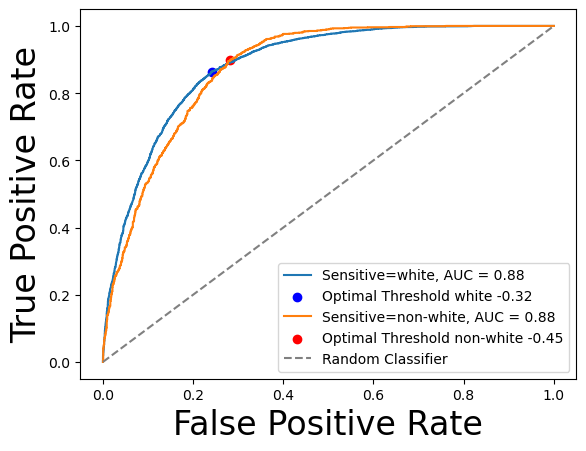

In [50]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
# For compas : model[6]
# For income : model[8]
#(model_name,model) = loaded_models[6]

# by mean auc: 3, 24
model_idx = 240

(model_name,model) = loaded_models[model_idx]
print(model_name)

# model = model_unconstr

# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tpr_minus_fpr = tpr - fpr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    # Plot the optimal threshold point on the ROC curve
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')

# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
# print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :].shape)
with torch.inference_mode():
    predictions_0 = model(X_test_w)

    # Forward pass for subgroup with sensitive attribute A=1
    # print(X_test_nw.shape)
    predictions_1 = model(X_test_nw)

    # Plot ROC for sensitive attribute A=0
    plot_roc_curve_pr(predictions_0, y_test_w, sensitive_value=sensitive_value_0)

    # Plot ROC for sensitive attribute A=1
    plot_roc_curve_pr(predictions_1, y_test_nw, sensitive_value=sensitive_value_1)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
# plt.title(model_name)
plt.legend()
plt.show()

Plotting the ROC between TNRs and FNRs

torch.Size([10838, 15])
torch.Size([3160, 15])
0.11547656930452974
0.12420697577276525


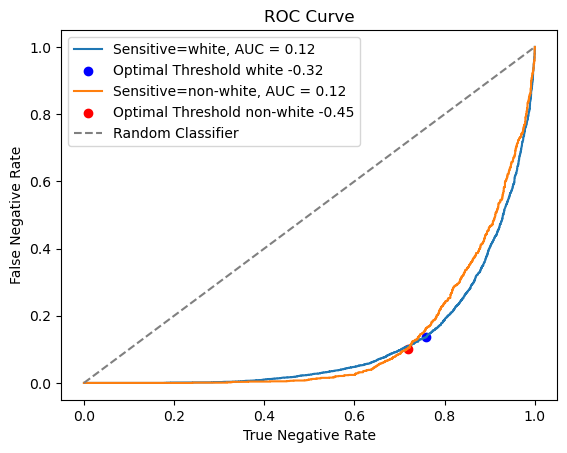

In [51]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
(model_name,model) = loaded_models[model_idx]


# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = (1-tpr)
    tnr = (1-fpr)
    roc_auc = auc(tnr, fnr)

    print(roc_auc)

    # Plot ROC curve
    plt.plot(tnr, fnr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    plt.scatter(tnr[optimal_threshold_index],fnr[optimal_threshold_index],  c='blue' if sensitive_value == sensitive_value_0 else 'red', label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    # Plot the optimal threshold point on the ROC curve
    # if sensitive_value==sensitive_value_1:
    #     plt.scatter(tnr[optimal_threshold_index], fnr[optimal_threshold_index], c='red', marker='o', label=f'Optimal Threshold female = {optimal_threshold:.2f}')
    # if sensitive_value==sensitive_value_0:
    #     plt.scatter(tnr[optimal_threshold_index], fnr[optimal_threshold_index], c='blue', marker='o', label=f'Optimal Threshold male = {optimal_threshold:.2f}')

model.eval()
print(X_test_w.shape)
predictions_0 = model(X_test_w).detach().numpy()
print(X_test_nw.shape)
predictions_1 = model(X_test_nw).detach().numpy()
plot_roc_curve_nr(predictions_0, y_test_w, sensitive_value=sensitive_value_0)
plot_roc_curve_nr(predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('True Negative Rate')
plt.ylabel('False Negative Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Level 2 : Could select or reject a model based on the Predicted label distribution conditioned on Sensitive attribute value.

If the distribution of predicted labels conditioned on Sensitive attributes has a high overlap(low KL divergence) that means the model predictions are insensitive to the protected class value. This distribution also helps select the decision boundary for making final predictions.

sslalm_test_0.005_trial0.pt


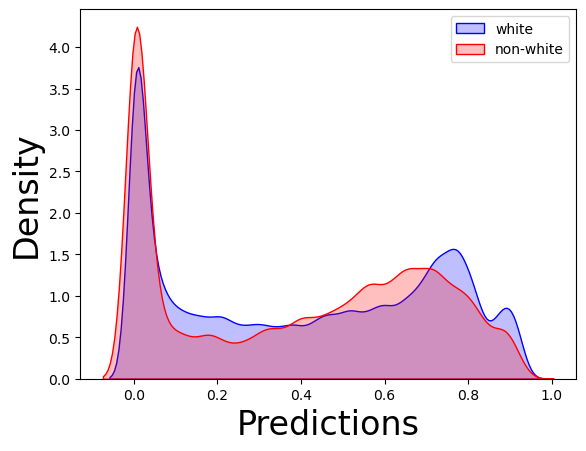

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# For compas : model[6]
# For income : model[8]
#(model_name,model) = loaded_models[6]

(model_name,model) = loaded_models[model_idx]
print(model_name)
# model = model_unconstr

# Assuming you have predictions for male and female
# predictions_0_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))
# predictions_1_tensor = model(X_test_nw)

predictions_0_tensor = torch.nn.functional.sigmoid(model(X_test_w))
predictions_1_tensor = torch.nn.functional.sigmoid(model(X_test_nw))

# Convert predictions tensors to numpy arrays
predictions_0 = predictions_0_tensor.detach().numpy()
predictions_1 = predictions_1_tensor.detach().numpy()

# Create density distribution plot
sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True,bw_adjust=.4)
sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True,bw_adjust=.4)

# Add labels and title
plt.xlabel('Predictions', fontsize=24)
plt.ylabel('Density', fontsize=24)
#plt.title('Density Distribution conditioned on Sensitive attribute')

# Show legend
plt.legend()

# Show plot
plt.show()

In [50]:
a = 0.005
print(f'{a:.0E}')

5E-03


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pandas as pd

# Define function to calculate metrics based on threshold
def calculate_metrics(threshold):
    #acc_values = []

    # Calculate predictions for both sensitive values
    predictions_0_tensor = model(X_test_w)
    predictions_1_tensor = model(X_test_nw)
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    
    outputs = model.evaluate(model.to_backend(x_scaled))
    predictions = (outputs >= threshold)

    true = y

    df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
    df_out["pred_labels"] = np.array(predictions).astype(int)
    df_out["true_labels"] = np.array(true).astype(int)

    acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]]) / len(df_out)
    #acc_values.append(acc)

    # True Positives, False Positives, True Negatives, False Negatives
    # True Positives, False Positives, True Negatives, False Negatives
    tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

    tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

    # Additional calculations
    fpr_sensitive_1 = fp_sensitive_1 / (fp_sensitive_1 + tn_sensitive_1) 
    tpr_sensitive_1 = tp_sensitive_1 / (tp_sensitive_1 + fn_sensitive_1) 
    fpr_sensitive_0 = fp_sensitive_0 / (fp_sensitive_0 + tn_sensitive_0) 
    tpr_sensitive_0 = tp_sensitive_0 / (tp_sensitive_0 + fn_sensitive_0) 

    fnr_sensitive_1 = fn_sensitive_1 / (fn_sensitive_1 + tp_sensitive_1) 
    tnr_sensitive_1 = tn_sensitive_1 / (tn_sensitive_1 + fp_sensitive_1)
    fnr_sensitive_0 = fn_sensitive_0 / (fn_sensitive_0 + tp_sensitive_0) 
    tnr_sensitive_0 = tn_sensitive_0 / (tn_sensitive_0 + fp_sensitive_0)

    ppr_sensitive_0 = (tp_sensitive_0 + fp_sensitive_0) / len(df_out)
    ppr_sensitive_1 = (tp_sensitive_1 + fp_sensitive_1) / len(df_out)

    neg_precision_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fn_sensitive_0)
    neg_precision_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fn_sensitive_1)
    precision_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fp_sensitive_0)
    precision_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fp_sensitive_1)

    return {
        'tpr_'+str(sensitive_value_1): tpr_sensitive_1,
        'fpr_'+str(sensitive_value_1): fpr_sensitive_1,
        'tpr_'+str(sensitive_value_0): tpr_sensitive_0,
        'fpr_'+str(sensitive_value_0): fpr_sensitive_0,
        'fnr_'+str(sensitive_value_1): fnr_sensitive_1,
        'tnr_'+str(sensitive_value_1): tnr_sensitive_1,
        'fnr_'+str(sensitive_value_0): fnr_sensitive_0,
        'tnr_'+str(sensitive_value_0): tnr_sensitive_0,
        'ppr_'+str(sensitive_value_0): ppr_sensitive_0,
        'ppr_'+str(sensitive_value_1): ppr_sensitive_1,
        'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0,
        'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1,
        'precision_'+str(sensitive_value_0): precision_sensitive_0,
        'precision_'+str(sensitive_value_1): precision_sensitive_1,
        'acc': acc
    }

# Define function to calculate predictions and update plot based on threshold
def calculate_predictions(threshold):
    # Calculate predictions for both sensitive values
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    predictions_0_tensor = model(X_test_w)
    predictions_1_tensor = model(X_test_nw)
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    # Create density distribution plot
    sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True, ax = ax[0])
    sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True, ax = ax[0])

    # Add labels and title
    ax[0].set_xlabel('Predictions')
    ax[0].set_ylabel('Density')
    ax[0].set_title('Density Distribution conditioned on Sensitive attribute')
    ax[0].axvline(x=threshold, color='green', linestyle='--', label='Threshold')
    ax[0].legend()

    metrics = calculate_metrics(threshold)

    categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
    values3 = [metrics['tpr_'+str(sensitive_value_0)], metrics['fpr_'+str(sensitive_value_0)], 
               metrics['tnr_'+str(sensitive_value_0)], metrics['fnr_'+str(sensitive_value_0)]]
    values4 = [metrics['tpr_'+str(sensitive_value_1)], metrics['fpr_'+str(sensitive_value_1)], 
               metrics['tnr_'+str(sensitive_value_1)], metrics['fnr_'+str(sensitive_value_1)]]
    bar_width = 0.3
    index = np.arange(len(categories2))

    ax[1].bar(index, values3, color='blue', width=bar_width, label='S='+str(sensitive_value_0), alpha=0.5)
    ax[1].bar(index + bar_width, values4, color='red', width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)
    ax[1].set_xticks(index + bar_width / 2)
    ax[1].set_xticklabels(categories2)
    ax[1].set_ylabel("Fraction")
    ax[1].legend()
    ax[1].set_title("Performance metrics over dataset")

    # Show legend
    

    # Show plot
    plt.show()

    # Calculate and display metrics
    
    f1_sens_0 = 2*(metrics['tpr_'+str(sensitive_value_0)]*metrics['precision_'+str(sensitive_value_0)])/(metrics['tpr_'+str(sensitive_value_0)] + metrics['precision_'+str(sensitive_value_0)])
    f1_sens_1 = 2*(metrics['tpr_'+str(sensitive_value_1)]*metrics['precision_'+str(sensitive_value_1)])/(metrics['tpr_'+str(sensitive_value_1)] + metrics['precision_'+str(sensitive_value_1)])
    
    # Calculate and display metrics
    
    print("Accuracy:",metrics['acc'])
    print("precision "+str(sensitive_value_0)+":", metrics['precision_'+str(sensitive_value_0)], "   precision "+str(sensitive_value_1)+":", metrics['precision_'+str(sensitive_value_1)])
    print("recall "+str(sensitive_value_0)+":", metrics['tpr_'+str(sensitive_value_0)], "   recall "+str(sensitive_value_1)+":", metrics['tpr_'+str(sensitive_value_1)])
    print("FPR "+str(sensitive_value_0)+":", metrics['fpr_'+str(sensitive_value_0)], "   FPR "+str(sensitive_value_1)+":", metrics['fpr_'+str(sensitive_value_1)])
    print("F1 "+str(sensitive_value_0)+":", f1_sens_0, "   F1 "+str(sensitive_value_1)+":", f1_sens_1)




The decision threshold range can be usually determined from the ROC curves by analysing the optimal threshold values for sensitive attributes and swiping in a window containing the values. 

In [52]:
#select min and max values to view the metrics

######INCOME#######
#min_thresh = 0.446
#max_thresh = 0.460
######INCOME#######

######COMPAS#######
min_thresh = 0.461
max_thresh = 0.467
######COMPAS#######

steps = int((max_thresh - min_thresh)/50.)
# Create slider for selecting the shift value
shift_slider = FloatSlider(value=min_thresh, min=min_thresh, max=max_thresh, step=steps, description='Decision boundary:', readout_format='.4f')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        calculate_predictions(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox

NameError: name 'FloatSlider' is not defined

Display various metrics for different threshold values in a range

In [ ]:
thresholds = np.linspace(min_thresh, max_thresh, 20)
acc_values = []
fpr_sensitive_1_values = []
tpr_sensitive_1_values = []
fpr_sensitive_0_values = []
tpr_sensitive_0_values = []
fnr_sensitive_1_values = []
tnr_sensitive_1_values = []
fnr_sensitive_0_values = []
tnr_sensitive_0_values = []
ppr_sensitive_0_values = []
ppr_sensitive_1_values = []
neg_precision_sensitive_0_values = []
neg_precision_sensitive_1_values = []
precision_sensitive_0_values = []
precision_sensitive_1_values = []

for thresh in thresholds:
    metrics = calculate_metrics(thresh)

    fpr_sensitive_1_values.append(metrics['fpr_'+str(sensitive_value_1)])
    tpr_sensitive_1_values.append(metrics['tpr_'+str(sensitive_value_1)])
    fpr_sensitive_0_values.append(metrics['fpr_'+str(sensitive_value_0)])
    tpr_sensitive_0_values.append(metrics['tpr_'+str(sensitive_value_0)])

    fnr_sensitive_1_values.append(metrics['fnr_'+str(sensitive_value_1)])
    tnr_sensitive_1_values.append(metrics['tnr_'+str(sensitive_value_1)])
    fnr_sensitive_0_values.append(metrics['fnr_'+str(sensitive_value_0)])
    tnr_sensitive_0_values.append(metrics['tnr_'+str(sensitive_value_0)])

    ppr_sensitive_0_values.append(metrics['ppr_'+str(sensitive_value_0)])
    ppr_sensitive_1_values.append(metrics['ppr_'+str(sensitive_value_1)])

    neg_precision_sensitive_1_values.append(metrics['neg_precision_'+str(sensitive_value_1)])
    neg_precision_sensitive_0_values.append(metrics['neg_precision_'+str(sensitive_value_0)])
    precision_sensitive_1_values.append(metrics['precision_'+str(sensitive_value_1)])
    precision_sensitive_0_values.append(metrics['precision_'+str(sensitive_value_0)])
    acc_values.append(metrics['acc'])



In [ ]:
data = {
    'thresh' : thresholds,
    'acc': acc_values, 
    'fpr_'+str(sensitive_value_1): fpr_sensitive_1_values,
    'tpr_'+str(sensitive_value_1): tpr_sensitive_1_values,
    'fpr_'+str(sensitive_value_0): fpr_sensitive_0_values,
    'tpr_'+str(sensitive_value_0): tpr_sensitive_0_values,
    'fnr_'+str(sensitive_value_1): fnr_sensitive_1_values,
    'tnr_'+str(sensitive_value_1): tnr_sensitive_1_values,
    'fnr_'+str(sensitive_value_0): fnr_sensitive_0_values,
    'tnr_'+str(sensitive_value_0): tnr_sensitive_0_values,
    'ppr_'+str(sensitive_value_0): ppr_sensitive_0_values,
    'ppr_'+str(sensitive_value_1): ppr_sensitive_1_values,
    'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0_values,
    'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1_values,
    'precision_'+str(sensitive_value_0): precision_sensitive_0_values,
    'precision_'+str(sensitive_value_1): precision_sensitive_1_values
}

# Create DataFrame
plot_df = pd.DataFrame(data)

In [ ]:
plot_df.sort_values(by='acc')

,thresh,acc,fpr_black,tpr_black,fpr_white,tpr_white,fnr_black,tnr_black,fnr_white,tnr_white,ppr_white,ppr_black,neg_precision_white,neg_precision_black,precision_white,precision_black
9,0.463842,0.637626,0.531513,0.754,0.300562,0.638889,0.246,0.468487,0.361111,0.699438,0.169192,0.397727,0.732353,0.644509,0.600746,0.598413
8,0.463526,0.637626,0.531513,0.754,0.300562,0.638889,0.246,0.468487,0.361111,0.699438,0.169192,0.397727,0.732353,0.644509,0.600746,0.598413
7,0.463211,0.637626,0.531513,0.754,0.300562,0.638889,0.246,0.468487,0.361111,0.699438,0.169192,0.397727,0.732353,0.644509,0.600746,0.598413
10,0.464158,0.638258,0.529412,0.754,0.300562,0.638889,0.246,0.470588,0.361111,0.699438,0.169192,0.397096,0.732353,0.645533,0.600746,0.599364
3,0.461947,0.638258,0.531513,0.756,0.300562,0.638889,0.244,0.468487,0.361111,0.699438,0.169192,0.398359,0.732353,0.646377,0.600746,0.599049
4,0.462263,0.638258,0.531513,0.756,0.300562,0.638889,0.244,0.468487,0.361111,0.699438,0.169192,0.398359,0.732353,0.646377,0.600746,0.599049
5,0.462579,0.638258,0.531513,0.756,0.300562,0.638889,0.244,0.468487,0.361111,0.699438,0.169192,0.398359,0.732353,0.646377,0.600746,0.599049
6,0.462895,0.638258,0.531513,0.756,0.300562,0.638889,0.244,0.468487,0.361111,0.699438,0.169192,0.398359,0.732353,0.646377,0.600746,0.599049
0,0.461000,0.639520,0.542017,0.770,0.300562,0.638889,0.230,0.457983,0.361111,0.699438,0.169192,0.405934,0.732353,0.654655,0.600746,0.598756
1,0.461316,0.639520,0.542017,0.770,0.300562,0.638889,0.230,0.457983,0.361111,0.699438,0.169192,0.405934,0.732353,0.654655,0.600746,0.598756


In [ ]:
plot_df['net_pres_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['precision_'+str(sensitive_value_0)]
plot_df['net_pres_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['precision_'+str(sensitive_value_1)]

In [ ]:
plot_df['F1_'+str(sensitive_value_0)] = 2*plot_df['precision_'+str(sensitive_value_0)]*plot_df['tpr_'+str(sensitive_value_0)]/(plot_df['precision_'+str(sensitive_value_0)] + plot_df['tpr_'+str(sensitive_value_0)])
plot_df['F1_'+str(sensitive_value_1)] = 2*plot_df['precision_'+str(sensitive_value_1)]*plot_df['tpr_'+str(sensitive_value_1)]/(plot_df['precision_'+str(sensitive_value_1)] + plot_df['tpr_'+str(sensitive_value_1)])

In [ ]:
plot_df['neg_F1_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['tnr_'+str(sensitive_value_0)]/(plot_df['neg_precision_'+str(sensitive_value_0)] + plot_df['tnr_'+str(sensitive_value_0)])
plot_df['neg_F1_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['tnr_'+str(sensitive_value_1)]/(plot_df['neg_precision_'+str(sensitive_value_1)] + plot_df['tnr_'+str(sensitive_value_1)])

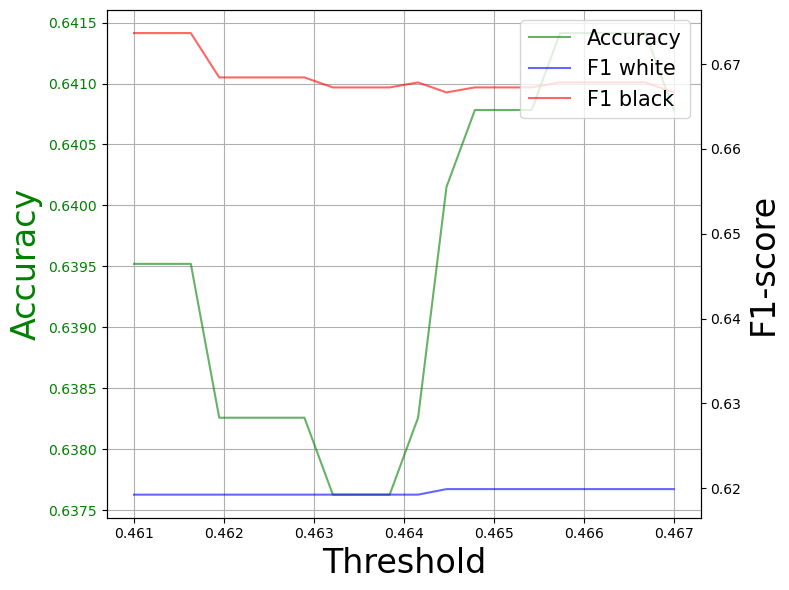

In [ ]:
import matplotlib.pyplot as plt

# Your DataFrame plot_df
# Assuming plot_df contains columns: 'thresh', 'acc', 'net_pres_male', 'net_pres_female'

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plotting accuracy on the left y-axis
color = 'green'
ax1.set_xlabel('Threshold', fontsize=24)
ax1.set_ylabel('Accuracy', color=color, fontsize=24)
ax1.plot(plot_df['thresh'], plot_df['acc'], label='Accuracy', color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for precision
ax2 = ax1.twinx()

# Plotting precision on the right y-axis
#color = 'red'
ax2.set_ylabel('F1-score', fontsize=24)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_0)], label='F1 '+str(sensitive_value_0), color='blue', alpha=0.6)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_1)], label='F1 '+str(sensitive_value_1), color='red', alpha=0.6)
ax2.tick_params(axis='y')

# Title and legend
#plt.title('Accuracy and F1-score vs Threshold', fontsize=15)

# Adjusting legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=15)

# Grid
ax1.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [ ]:
#######INCOME########
#threshh = 0.455
#######INCOME########

#######COMPAS########

#######COMPAS########
#(model_name,model) = loaded_models[8]
(model_name,model) = loaded_models[model_idx]

outputs = model.evaluate(model.to_backend(x_scaled))
predictions = (outputs >= 0.456)
true = y

In [ ]:
############  FOR INCOME  #############
df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
df_out["pred_labels"] = np.array(predictions).astype(int)
df_out["true_labels"] = np.array(true).astype(int)

In [ ]:
# ############ FOR COMPAS ############
# df_out = pd.DataFrame(np.array(x_raw), columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid'])
# df_out["pred_labels"] = np.array(predictions).astype(int)
# df_out["true_labels"] = np.array(true).astype(int)

In [ ]:
acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]])/len(df_out)
print(acc)

0.6382575757575758


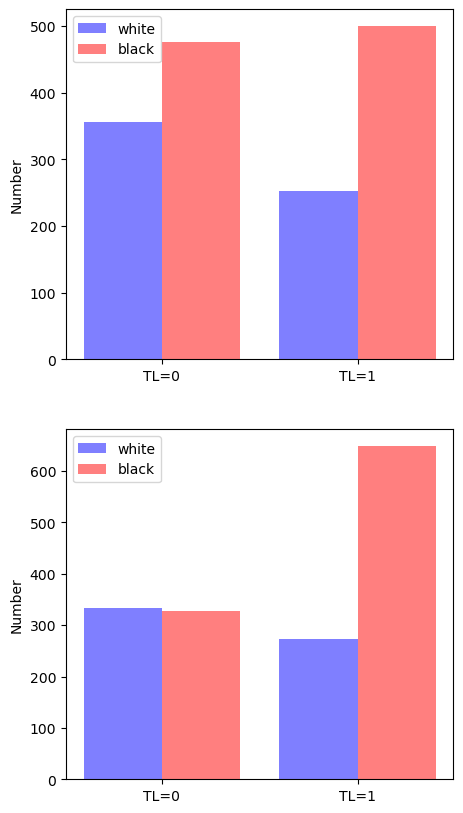

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = [category_0, category_1]
values1 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 1)])]
values2 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
#ax[0].set_title("Distribution of True labels across "+ str(sensitive))
ax[0].legend()


categories2 = [category_0, category_1]
values3 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 1)])]
values4 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
#ax[1].set_title("Distribution of Predicted labels across "+str(sensitive))
ax[1].legend()

In [ ]:
tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

In [ ]:
fpr_sensitive_1 = fp_sensitive_1/(fp_sensitive_1 + tn_sensitive_1)
tpr_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fn_sensitive_1)
fpr_sensitive_0 = fp_sensitive_0/(fp_sensitive_0 + tn_sensitive_0)
tpr_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fn_sensitive_0)

fnr_sensitive_1 = fn_sensitive_1/(fn_sensitive_1 + tp_sensitive_1)
tnr_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fp_sensitive_1)
fnr_sensitive_0 = fn_sensitive_0/(fn_sensitive_0 + tp_sensitive_0)
tnr_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fp_sensitive_0)

Various rates achieved with the particular model selection (values directly taken from a general unconstrained optimizion problem (Adam for ex))

In [ ]:
if DATASET == 'compas':
    values1 = [0.41, 0.15, 0.85, 0.58]
    values2 = [0.64, 0.32, 0.66, 0.34]
elif DATASET == 'income':
    values1 = [0.48, 0.08, 0.65, 0.32]
    values2 = [0.28, 0.01, 0.41, 0.14]

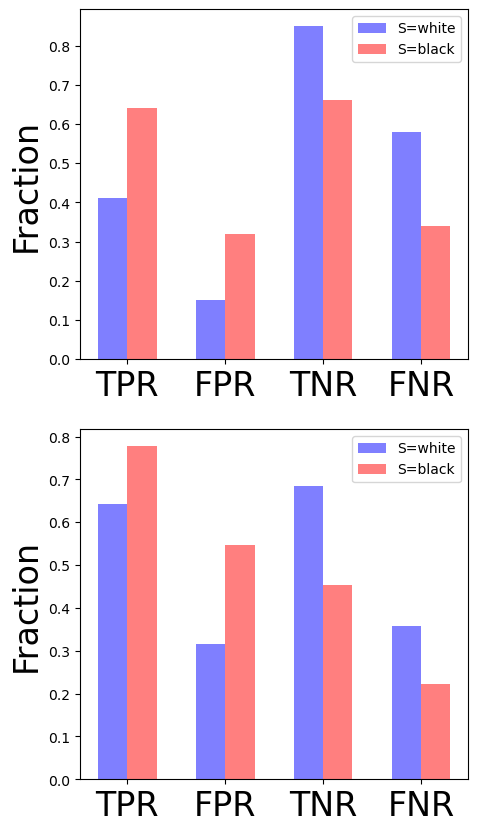

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['TPR', 'FPR', 'TNR', 'FNR']
# values1 = [0.41, 0.15, 0.85, 0.58]
# values2 = [0.64, 0.32, 0.66, 0.34]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Fraction", fontsize=24)
#ax[0].set_title('Performance metrics without constraints')
ax[0].legend()


categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
values3 = [tpr_sensitive_0, fpr_sensitive_0, tnr_sensitive_0, fnr_sensitive_0]
values4 = [tpr_sensitive_1, fpr_sensitive_1, tnr_sensitive_1, fnr_sensitive_1]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Fraction", fontsize=24)
#ax[1].set_title('Performance metrics with constraints')
ax[1].legend()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function to plot y = sin(x - value_slider)
def plot_sin(shift):
    x = np.linspace(0, np.pi * 2, 1000)
    y = np.sin(x - shift)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('sin(x - shift)')
    plt.title('Plot of y = sin(x - shift)')
    plt.grid(True)
    plt.show()

# Create slider for selecting the shift value
shift_slider = FloatSlider(value=0, min=0, max=np.pi/2, step=0.01, description='Shift:')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        plot_sin(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox